# Traffic Analysis

A trained YOLOv8n model is used to generate tabular traffic flow data from images captured at two-minute intervals from a live feed. The goal is to develop an anomaly detection system that leverages this tabular traffic flow data.

## To-do
### Object Detection 
- annotate more data with active learning 
- start training and detecting on other cameras to cross compare trends

### EDA tabular data 
- Look at hour level histograms across the different days of the week
- Explore anomaly detection feasibility 

## Packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import os 
from ultralytics import YOLO
import cv2

## Constants

In [25]:
SEED=53456
CAMERA = '147'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# setting up the paths
cwd=os.getcwd()
root = os.path.dirname(cwd)

# data paths
processed_image_dir = os.path.join(root, 'dat','processed_images')
image_folder = os.path.join(processed_image_dir,CAMERA,'2024-12-11')
output_folder = os.path.join(root, 'dat','output')
camera_dir = os.path.join(processed_image_dir, CAMERA)
tabular_csv_path = os.path.join(output_folder, 'traffic_oneway.csv')

# model paths
run_dir = os.path.join(root, 'runs','detect')
best_weights_path  = os.path.join(run_dir, 'train15', 'weights','best.pt')

## Functions

In [13]:
def plot_boxes(result, color_map=None):
    if color_map is None:
        color_map = {0: 'red', 1: 'blue'}

    image_rgb = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    boxes = result.boxes
    for box, cls, conf in zip(boxes.xywh, boxes.cls, boxes.conf):
        cls = int(cls)
        x_center, y_center, width, height = box
        rect = plt.Rectangle((x_center - width / 2, y_center - height / 2), width, height, fill=True, color=color_map[cls], alpha=0.3)
        plt.gca().add_patch(rect)
        plt.text(x_center, y_center, f'{conf:.2f}', fontsize=5, color='white', verticalalignment='center', horizontalalignment='center')

## Object detection: YOLOv8n

In [3]:
# Load a model
model = YOLO(best_weights_path)  # fine-tuned yolov8n model

### Single image detection 


0: 320x448 5 incomings, 11 outgoings, 54.7ms
Speed: 2.0ms preprocess, 54.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 448)


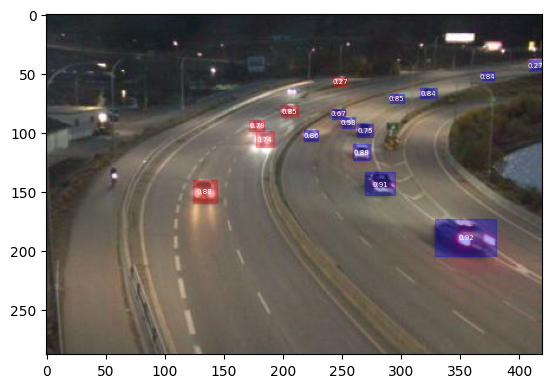

In [16]:
image_file_path = os.path.join(processed_image_dir,CAMERA,'2024-11-15', 'traffic_202411151644.jpg')
image_paths = [image_file_path]
results = model(image_paths)  

plot_boxes(results[0])

### Detect cars from images in a day

In [ ]:
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
results = model(image_paths)  


dict_data = dict(incoming=[], outgoing=[])
# Process results list
for result in results:
    boxes = result.boxes  
    dict_temp_count = dict(incoming=0, outgoing=0)
    vals, counts = np.unique(boxes.cls.cpu().numpy(), return_counts=True)
    for val, count in zip(vals, counts):
        dict_temp_count[result.names[val]] = count

    for key, item in dict_temp_count.items():
        dict_data[key].append(item)

### Plot results

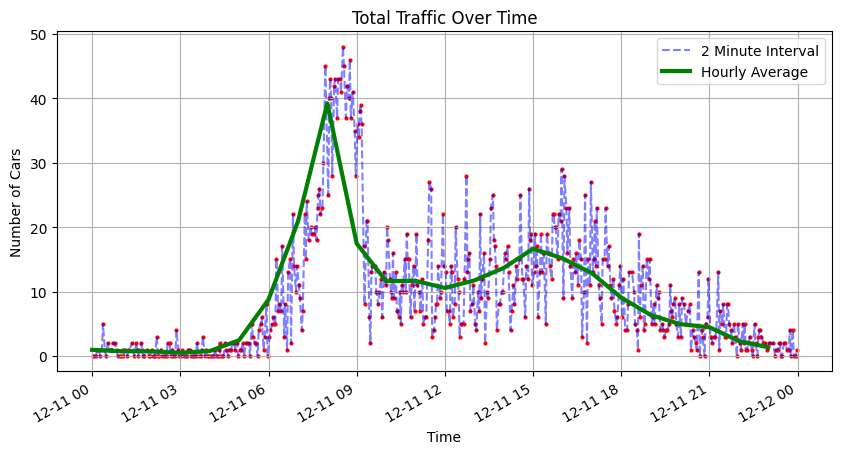

In [37]:
time_stamps = [
    datetime.strptime(string[8:-4], '%Y%m%d%H%M') for string in os.listdir(image_folder)
]

df = pd.DataFrame(dict_data)
df['time'] = time_stamps
df['image_paths'] = image_paths
df['num_cars'] = df['incoming'] + df['outgoing']
df['net'] = df['incoming'] - df['outgoing']

df.set_index('time', inplace=True)
df_hourly = df[['num_cars', 'net']].resample('h').mean().reset_index()


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.num_cars, label='2 Minute Interval', color='blue', linestyle='dashed', alpha=0.5)
plt.scatter(df.index, df.num_cars, s=4, color='red')

plt.plot(df_hourly['time'], df_hourly['num_cars'], label='Hourly Average', color='green', lw=3)

# Formatting the x-axis for better readability
plt.gcf().autofmt_xdate()  # Auto formats dates for better display
plt.xlabel('Time')
plt.ylabel('Number of Cars')
plt.title('Total Traffic Over Time')
plt.grid(True)
plt.legend()
plt.show()


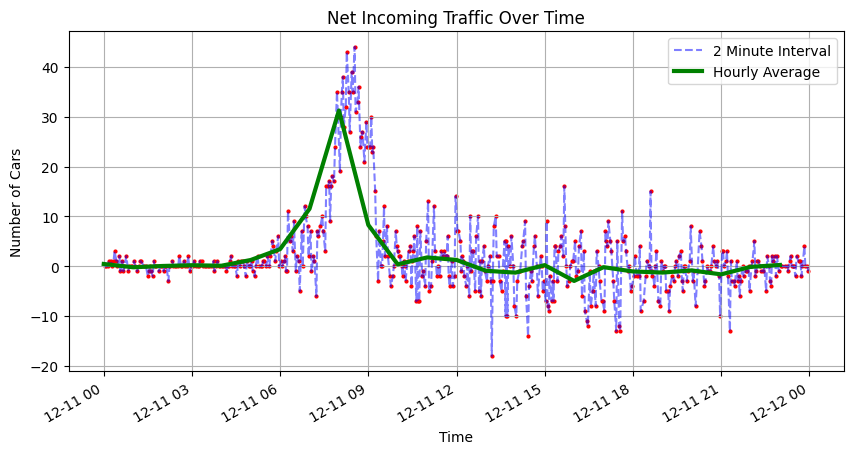

In [36]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.net, label='2 Minute Interval', color='blue', linestyle='dashed', alpha=0.5)
plt.scatter(df.index, df.net, s=4, color='red')

plt.plot(df_hourly['time'], df_hourly['net'], label='Hourly Average', color='green', lw=3)

# Formatting the x-axis for better readability
plt.gcf().autofmt_xdate()  # Auto formats dates for better display
plt.xlabel('Time')
plt.ylabel('Number of Cars')
plt.title('Net Incoming Traffic Over Time')
plt.grid(True)
plt.legend()
plt.show()


### Generating tabular data from all the available dates

In [ ]:
df = pd.DataFrame({'time':[], 'class':[], 'confidence':[], 'num_cars':[], 'incoming':[], 'outgoing':[]})
date_folders = os.listdir(camera_dir)

for date_folder in tqdm(date_folders):
    date_dir = os.path.join(camera_dir, date_folder)
    image_files = os.listdir(date_dir)
    image_paths = [os.path.join(date_dir, file) for file in image_files]
    if len(image_paths) == 0:
        continue
    results = model(image_paths)  
    for result, file in zip(results, image_files):
        cls = result.boxes.cls
        vals, counts = np.unique(cls.cpu().numpy(), return_counts=True)
        conf = result.boxes.conf
        num_cars = len(cls)
        date_string = file.split('_')[1].split('.')[0]
        date_object = datetime.strptime(date_string, '%Y%m%d%H%M')
        row = pd.DataFrame({'time':[date_object], 'class':[cls], 'confidence':[conf], 'num_cars':[num_cars], 'incoming':[0], 'outgoing':[0]})
        for val, count in zip(vals, counts):
            row[result.names[val]] = count
        df = pd.concat([df, row], ignore_index=True)

df['camera']=CAMERA

In [19]:
df.to_csv(tabular_csv_path, index=False)

## Analyse tabular data

### Loading file

In [48]:
df = pd.read_csv(tabular_csv_path)

### Prepping dataframe

In [53]:
df['net'] = df['incoming'] - df['outgoing']

#group time column by days of the week 
df['time'] = pd.to_datetime(df['time'])
df['day_of_week'] = df['time'].dt.day_name()

#group time column by hours of the day
df['hour_of_day'] = df['time'].dt.hour 

df['time'].min(), df['time'].max()

(Timestamp('2024-10-28 00:02:00'), Timestamp('2024-12-20 17:44:00'))

### Checking data distribution

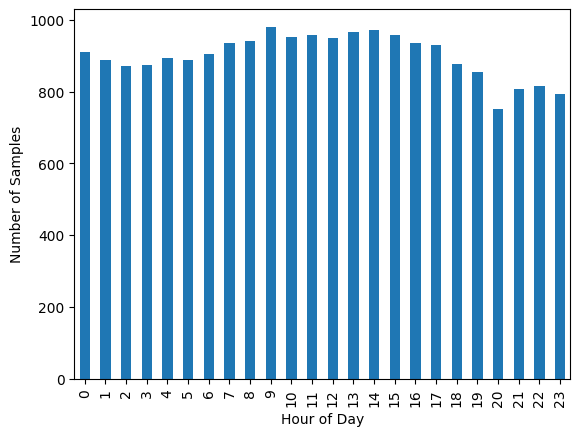

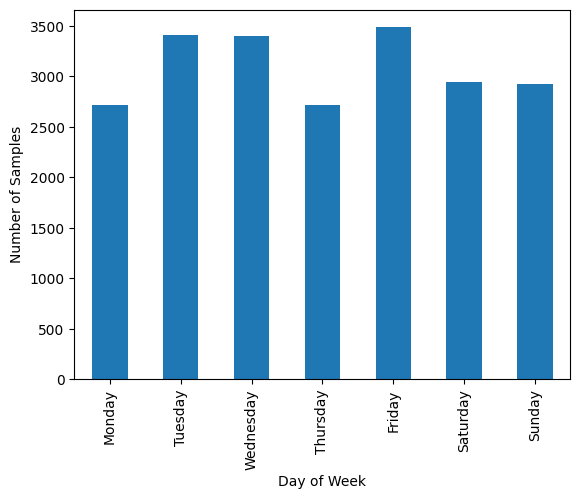

In [47]:
df['hour_of_day'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Samples')
plt.show()

df['day_of_week'].value_counts().loc[days].plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Samples')
plt.show()

### Inspecting for trends

Interestingly Monday and Friday does not contain the same morning traffic peaks Tuesday, Wednesday, and Thursday. Consider if mean or median is a better summary statistic here. 

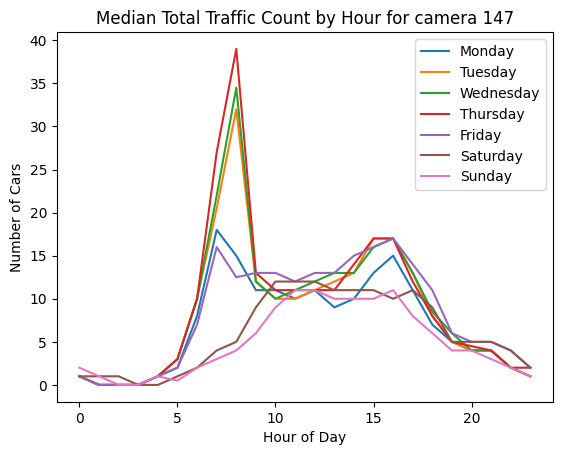

In [58]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['num_cars'].median().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Median Total Traffic Count by Hour for camera {CAMERA}')

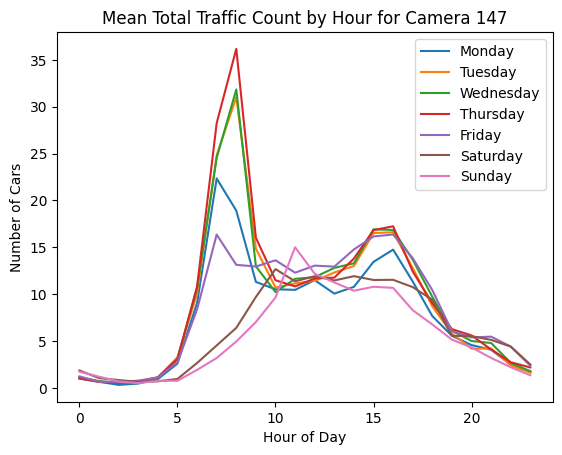

In [57]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['num_cars'].mean().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Mean Total Traffic Count by Hour for Camera {CAMERA}')

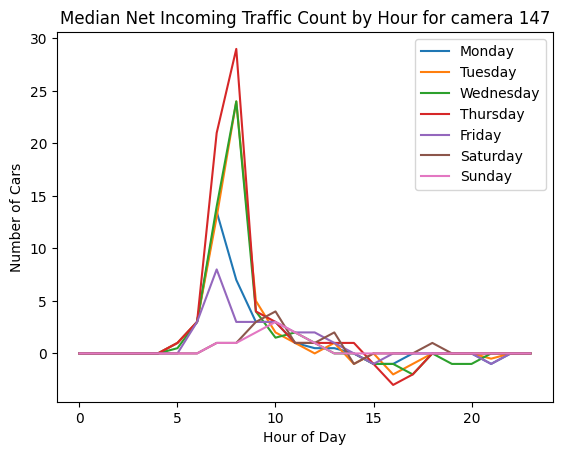

In [56]:
for day in days:
    df_day = df[df['day_of_week'] == day]
    df_day.groupby('hour_of_day')['net'].median().plot(label=day, legend=True)
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Median Net Incoming Traffic Count by Hour for camera {CAMERA}')